
# Fraud Detection in Financial Transactions (Non-Deep Learning)

**Course:** IT5022 - Fundamentals of Machine Learning (MSc AI)  
**Student:** MS25948592 — N.G.S.D. Nanayakkara  
**Dataset:** [Fraudulent Transactions Data (Kaggle)](https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data)

**Models:** Logistic Regression (baseline, interpretable) & Random Forest (nonlinear, robust)

> This notebook is optimized for large data (≈6.3M rows). If your machine has limited RAM, enable **QUICK_EXPERIMENT** to downsample while preserving fraud cases.


In [1]:

# If you need to install missing packages, uncomment and run:
# !pip install pandas numpy scikit-learn matplotlib plotly imbalanced-learn polars


In [19]:

import os
import gc
import numpy as np
import pandas as pd
import zipfile
from pathlib import Path

try:
    import polars as pl
    POLARS_AVAILABLE = True
except Exception:
    POLARS_AVAILABLE = False

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Configuration

In [21]:
QUICK_EXPERIMENT = True
MAX_ROWS = 500_000
TRAIN_CUTOFF_STEP = 600

# Where to save dataset
DATA_DIR = Path("./data")
DATA_DIR.mkdir(exist_ok=True)

# Check if CSV already exists
CSV_FILENAME = "Fraud.csv"
csv_path = DATA_DIR / CSV_FILENAME

if not csv_path.exists():
    print("CSV not found locally, downloading from Kaggle...")
    os.system("kaggle datasets download -d chitwanmanchanda/fraudulent-transactions-data -p data")
    # Extract
    for file in DATA_DIR.glob("*.zip"):
        with zipfile.ZipFile(file, "r") as zip_ref:
            zip_ref.extractall(DATA_DIR)
        file.unlink()  # remove zip after extract
else:
    print("CSV already exists:", csv_path)


CSV already exists: data\Fraud.csv


## Load Data (Memory–Aware)

In [22]:

def read_data_pandas(path: str) -> pd.DataFrame:
    """Memory-aware CSV reader with dtype hints to reduce RAM usage."""
    dtype_map = {
        "step": "int32",
        "type": "category",
        "amount": "float32",
        "nameOrig": "category",
        "oldbalanceOrg": "float32",
        "newbalanceOrig": "float32",
        "nameDest": "category",
        "oldbalanceDest": "float32",
        "newbalanceDest": "float32",
        "isFraud": "int8",
        "isFlaggedFraud": "int8",
    }
    usecols = list(dtype_map.keys())
    df = pd.read_csv(path, usecols=usecols, dtype=dtype_map)
    return df

csv_path = os.path.join(DATA_DIR, CSV_FILENAME)
df = read_data_pandas(csv_path)
print(df.shape)
df.head()


(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0


## Exploratory Data Analysis (EDA)

In [23]:

print("Columns:", df.columns.tolist())
print("\ndtypes:\n", df.dtypes)
print("\nNull counts:\n", df.isna().sum())
print("\nClass distribution (isFraud):\n", df['isFraud'].value_counts(normalize=True))
print("\nTransaction type distribution:\n", df['type'].value_counts(normalize=True))


Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

dtypes:
 step                 int32
type              category
amount             float32
nameOrig          category
oldbalanceOrg      float32
newbalanceOrig     float32
nameDest          category
oldbalanceDest     float32
newbalanceDest     float32
isFraud               int8
isFlaggedFraud        int8
dtype: object

Null counts:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Class distribution (isFraud):
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

Transaction type distribution:
 type
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: proportion, dtype: fl

## Feature Engineering

In [24]:

df = df.copy()
df['tx_delta_orig'] = (df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']).astype('float32')
df['tx_delta_dest'] = (df['newbalanceDest'] - df['oldbalanceDest']).astype('float32')
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)
df.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,tx_delta_orig,tx_delta_dest
0,1,PAYMENT,9839.639648,170136.0,160296.359375,0.0,0.0,0,0,0.000977,0.0
1,1,PAYMENT,1864.280029,21249.0,19384.720703,0.0,0.0,0,0,-0.000732,0.0
2,1,TRANSFER,181.000000,181.0,0.000000,0.0,0.0,1,0,0.000000,0.0
3,1,CASH_OUT,181.000000,181.0,0.000000,21182.0,0.0,1,0,0.000000,-21182.0
4,1,PAYMENT,11668.139648,41554.0,29885.859375,0.0,0.0,0,0,0.000977,0.0


## Time-Aware Train/Test Split

In [25]:

train_mask = df['step'] <= TRAIN_CUTOFF_STEP
test_mask = df['step'] > TRAIN_CUTOFF_STEP

df_train = df.loc[train_mask].reset_index(drop=True)
df_test = df.loc[test_mask].reset_index(drop=True)

print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
print("Train fraud rate:", df_train['isFraud'].mean(), "| Test fraud rate:", df_test['isFraud'].mean())


Train shape: (6259047, 11), Test shape: (103573, 11)
Train fraud rate: 0.0010565506218438686 | Test fraud rate: 0.015448041477991368


### Optional: Quick Experiment Downsampling

In [26]:

def stratified_downsample(df_, y_col, max_rows, random_state=42):
    total = len(df_)
    if total <= max_rows:
        return df_
    minority = df_[df_[y_col] == 1]
    majority = df_[df_[y_col] == 0]
    remaining = max_rows - len(minority)
    remaining = max(remaining, 1000)
    maj_sample = majority.sample(n=min(remaining, len(majority)), random_state=random_state)
    return pd.concat([minority, maj_sample], axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)

if QUICK_EXPERIMENT:
    df_train = stratified_downsample(df_train, 'isFraud', MAX_ROWS, RANDOM_STATE)
    df_test = stratified_downsample(df_test, 'isFraud', max(MAX_ROWS//4, 250_000), RANDOM_STATE)
    print("After downsampling -> Train:", df_train.shape, "Test:", df_test.shape)


After downsampling -> Train: (500000, 11) Test: (103573, 11)


## Preprocessing Pipeline

In [27]:

target_col = 'isFraud'
categorical_cols = ['type']
numeric_cols = [c for c in df_train.columns if c not in categorical_cols + [target_col]]

X_train = df_train[categorical_cols + numeric_cols].copy()
y_train = df_train[target_col].astype('int8').copy()
X_test = df_test[categorical_cols + numeric_cols].copy()
y_test = df_test[target_col].astype('int8').copy()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numeric_transformer = StandardScaler(with_mean=False)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols),
    ],
    remainder='drop'
)


### Class Imbalance Strategy

In [28]:

classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
CLASS_WEIGHT_DICT = {0: class_weights[0], 1: class_weights[1]}
CLASS_WEIGHT_DICT


{0: np.float64(0.5067016358355612), 1: np.float64(37.80432481475881)}

## Model 1 — Logistic Regression

In [29]:

log_reg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LogisticRegression(
        max_iter=200,
        class_weight=CLASS_WEIGHT_DICT,
        solver='lbfgs'
    ))
])

log_reg.fit(X_train, y_train)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

roc_lr = roc_auc_score(y_test, y_proba_lr)
pr_lr = average_precision_score(y_test, y_proba_lr)

print(f"LogReg ROC-AUC: {roc_lr:.4f} | PR-AUC: {pr_lr:.4f}")
print("\nConfusion Matrix (0.5):\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report (0.5):\n", classification_report(y_test, y_pred_lr, digits=4))


LogReg ROC-AUC: 0.9941 | PR-AUC: 0.8277

Confusion Matrix (0.5):
 [[93517  8456]
 [    0  1600]]

Classification Report (0.5):
               precision    recall  f1-score   support

           0     1.0000    0.9171    0.9567    101973
           1     0.1591    1.0000    0.2745      1600

    accuracy                         0.9184    103573
   macro avg     0.5796    0.9585    0.6156    103573
weighted avg     0.9870    0.9184    0.9462    103573



<Figure size 640x480 with 0 Axes>

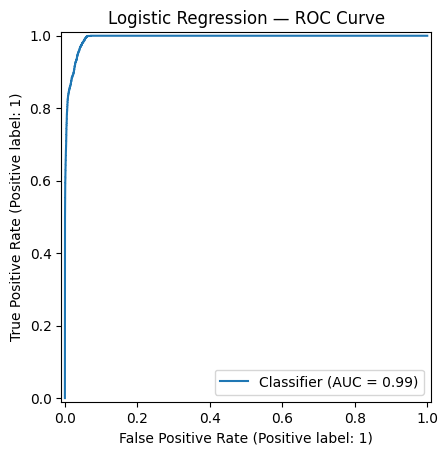

<Figure size 640x480 with 0 Axes>

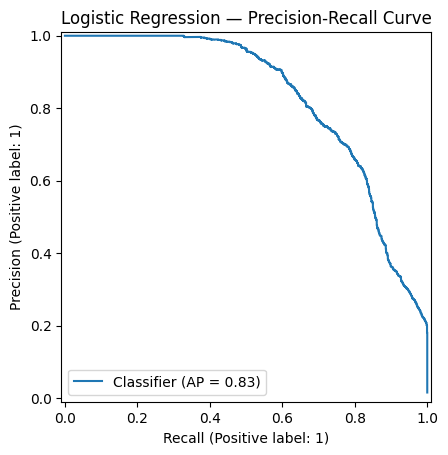

In [30]:

plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic Regression — ROC Curve")
plt.show()

plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic Regression — Precision-Recall Curve")
plt.show()


## Model 2 — Random Forest

In [31]:

rf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight=CLASS_WEIGHT_DICT
    ))
])

rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

roc_rf = roc_auc_score(y_test, y_proba_rf)
pr_rf = average_precision_score(y_test, y_proba_rf)

print(f"RandomForest ROC-AUC: {roc_rf:.4f} | PR-AUC: {pr_rf:.4f}")
print("\nConfusion Matrix (0.5):\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (0.5):\n", classification_report(y_test, y_pred_rf, digits=4))


RandomForest ROC-AUC: 1.0000 | PR-AUC: 1.0000

Confusion Matrix (0.5):
 [[101973      0]
 [     0   1600]]

Classification Report (0.5):
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    101973
           1     1.0000    1.0000    1.0000      1600

    accuracy                         1.0000    103573
   macro avg     1.0000    1.0000    1.0000    103573
weighted avg     1.0000    1.0000    1.0000    103573



<Figure size 640x480 with 0 Axes>

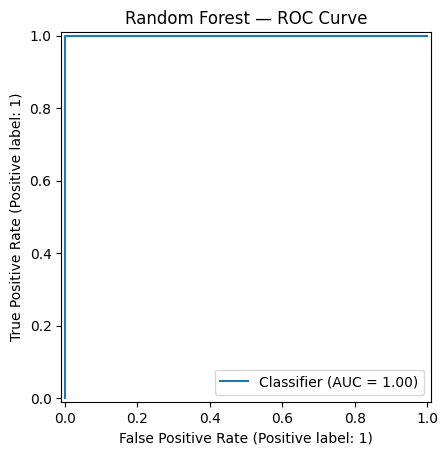

<Figure size 640x480 with 0 Axes>

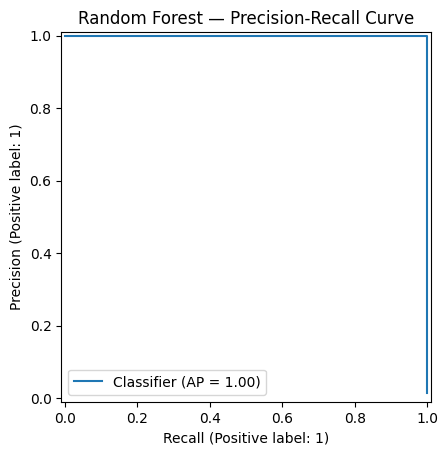

In [32]:

plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest — ROC Curve")
plt.show()

plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest — Precision-Recall Curve")
plt.show()


### Threshold Tuning (Business-Driven)

In [33]:

def evaluate_thresholds(y_true, y_scores, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 25)
    rows = []
    for t in thresholds:
        pred = (y_scores >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        rows.append({"threshold": t, "precision": precision, "recall": recall, "f1": f1, "tp": tp, "fp": fp, "fn": fn, "tn": tn})
    return pd.DataFrame(rows)

thres_table_lr = evaluate_thresholds(y_test, y_proba_lr)
thres_table_rf = evaluate_thresholds(y_test, y_proba_rf)

best_lr = thres_table_lr.sort_values("f1", ascending=False).head(1)
best_rf = thres_table_rf.sort_values("f1", ascending=False).head(1)
print("Best threshold (LR) by F1:\n", best_lr)
print("\nBest threshold (RF) by F1:\n", best_rf)


Best threshold (LR) by F1:
     threshold  precision    recall        f1    tp   fp   fn      tn
23   0.949167   0.680496  0.789375  0.730903  1263  593  337  101380

Best threshold (RF) by F1:
    threshold  precision  recall   f1    tp  fp  fn      tn
7   0.295833        1.0     1.0  1.0  1600   0   0  101973


### Feature Importance (Random Forest)

In [34]:

ohe = log_reg.named_steps['preprocess'].named_transformers_['cat']
num_features = numeric_cols
cat_features = list(ohe.get_feature_names_out(categorical_cols))
final_feature_names = cat_features + num_features

rf_model = rf.named_steps['clf']
importances = rf_model.feature_importances_

feat_imp = (pd.DataFrame({
    "feature": final_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False))

feat_imp.head(20)


,feature,importance
12,tx_delta_orig,0.400277
7,oldbalanceOrg,0.149249
8,newbalanceOrig,0.130564
6,amount,0.081641
3,type_PAYMENT,0.069662
4,type_TRANSFER,0.042184
13,tx_delta_dest,0.036234
0,type_CASH_IN,0.022360
10,newbalanceDest,0.020075
9,oldbalanceDest,0.017359


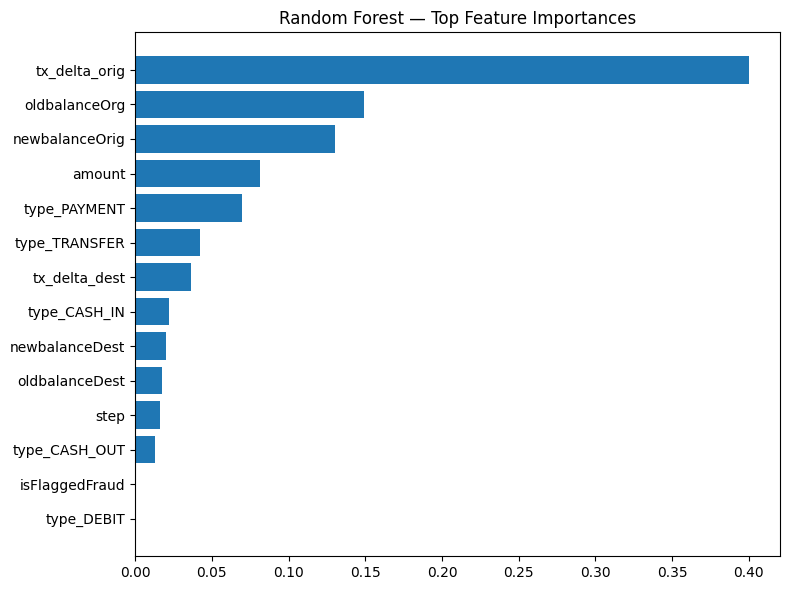

In [35]:

plt.figure(figsize=(8, 6))
top_k = min(20, len(feat_imp))
plt.barh(feat_imp.head(top_k)['feature'][::-1], feat_imp.head(top_k)['importance'][::-1])
plt.title("Random Forest — Top Feature Importances")
plt.tight_layout()
plt.show()


## Results Summary & Comparison

In [36]:

summary = pd.DataFrame({
    "model": ["Logistic Regression", "Random Forest"],
    "roc_auc": [roc_lr, roc_rf],
    "pr_auc": [pr_lr, pr_rf],
    "best_f1_threshold": [float(thres_table_lr.sort_values("f1", ascending=False).head(1)['threshold']),
                          float(thres_table_rf.sort_values("f1", ascending=False).head(1)['threshold'])],
    "best_f1": [float(thres_table_lr['f1'].max()), float(thres_table_rf['f1'].max())]
})
summary


C:\Users\sasan\AppData\Local\Temp\ipykernel_13504\151579043.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "best_f1_threshold": [float(thres_table_lr.sort_values("f1", ascending=False).head(1)['threshold']),
C:\Users\sasan\AppData\Local\Temp\ipykernel_13504\151579043.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(thres_table_rf.sort_values("f1", ascending=False).head(1)['threshold'])],


,model,roc_auc,pr_auc,best_f1_threshold,best_f1
0,Logistic Regression,0.994103,0.827739,0.949167,0.730903
1,Random Forest,1.000000,1.000000,0.295833,1.000000


### (Optional) Export Predictions

In [ ]:

# pd.DataFrame({"y_true": y_test, "proba_lr": y_proba_lr, "proba_rf": y_proba_rf}).to_csv("predictions.csv", index=False)


## Appendix — Export Notebook Source as Text

In [37]:

import json, pathlib
notebook_path = pathlib.Path("Fraud_Detection_Assignment.ipynb")
with open(notebook_path, "r", encoding="utf-8") as f:
    nb_json = json.load(f)

with open("Fraud_Detection_Assignment_source.txt", "w", encoding="utf-8") as f:
    f.write(json.dumps(nb_json, indent=2))

print("Exported to Fraud_Detection_Assignment_source.txt")


Exported to Fraud_Detection_Assignment_source.txt
